In [1]:
%%capture
pip install -r ../../requirements.txt

In [2]:
# Install the required packages
import sys 
import requests #needed to perform HTTP GET and POST requests
import numpy as np
import pandas as pd

# NLP
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Need this set to None otherwise text columns will truncate!
pd.set_option('display.max_colwidth', None) 

/Users/chrismcallister/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
text_data = pd.read_csv('../../data/posts.csv')

In [4]:
def calc_cosine_similarities(dataset, model_list, pos_query, neg_query, column_of_text = 'text'):

    # Initialize output df, which initially is the same as the input one. 
    output_data = dataset.copy()

    # Specify which column should be encoded
    text_to_encode = dataset[column_of_text].fillna(dataset['title']).fillna(' ')

    # Iterate over each model, encode the queries
    for model in model_list:

        print('started with model: ' + model)
    
        # Load in the model
        load_model = SentenceTransformer(model, device="cpu") 
    
        # Encode the positive post
        pos_embedding = load_model.encode(pos_query)
    
        # Encode the negative post
        neg_embedding = load_model.encode(neg_query)
        
        pos_sim_list = []
        neg_sim_list = []
        
        # Iterate over each post for that model, and calculate each post's cosine sim score to each query's embedding
        for post in text_to_encode:
    
            # Encode the post with chosen model
            embeddings = load_model.encode(post)
            
            # Compute similarity of positive / negative queries to the post:
            pos_sim_score = np.dot(pos_embedding, embeddings) / (np.linalg.norm(pos_embedding) * np.linalg.norm(embeddings))
            neg_sim_score = np.dot(neg_embedding, embeddings) / (np.linalg.norm(neg_embedding) * np.linalg.norm(embeddings))
            
           #  neg_similarities = cosine_similarity(embeddings.reshape(1, -1), neg_embedding.reshape(1, -1))
    
            # Append each post's similarity to the list
            pos_sim_list.append(pos_sim_score)
            neg_sim_list.append(neg_sim_score)
            
    
        # Once done for all posts, save scores to output df, under that model's name
        output_data[model + '_positive'] = pos_sim_list
        output_data[model + '_negative'] = neg_sim_list
    
        # Free memory after each model. Got a runtime error without this. 
        del load_model
        print("Done with " + model)

    return output_data
        


## Inputs to function

# Embed the query and compute similarity scores
negative_query = "Terrible experience with this company, never using them again."
positive_query = "I've had a fantastic experience with this company."  

data = text_data.copy()

# Models to try. Based off hugging face leaderboard: https://huggingface.co/spaces/mteb/leaderboard
model_names = ["multi-qa-mpnet-base-dot-v1", "thenlper/gte-large", "BAAI/bge-m3", "intfloat/multilingual-e5-small"]
## End Inputs

cosine_dim_data = calc_cosine_similarities(data.sample(100, random_state = 0), model_names, positive_query, negative_query)

started with model: multi-qa-mpnet-base-dot-v1
Done with multi-qa-mpnet-base-dot-v1
started with model: thenlper/gte-large
Done with thenlper/gte-large
started with model: BAAI/bge-m3
Done with BAAI/bge-m3
started with model: intfloat/multilingual-e5-small
Done with intfloat/multilingual-e5-small


In [5]:
cosine_dim_data.shape

(100, 17)

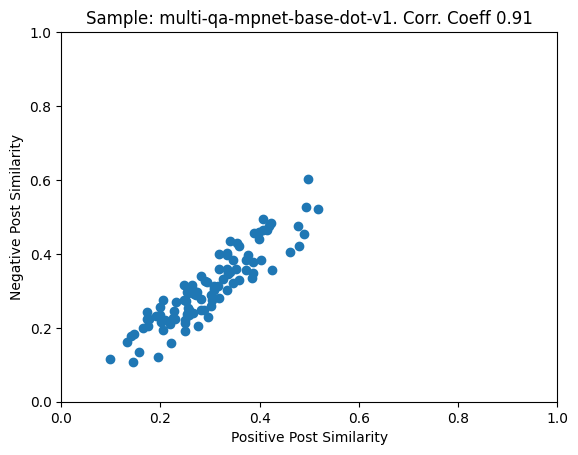

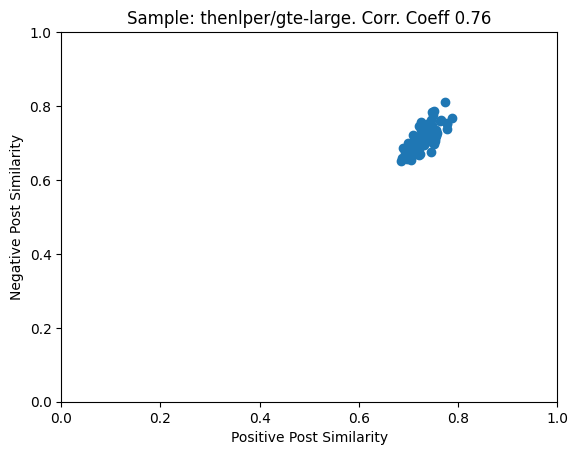

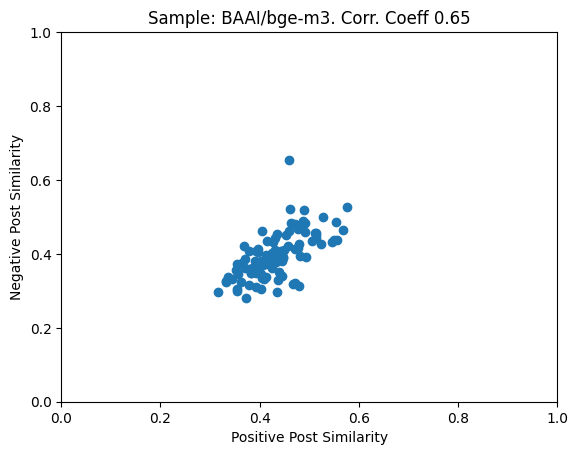

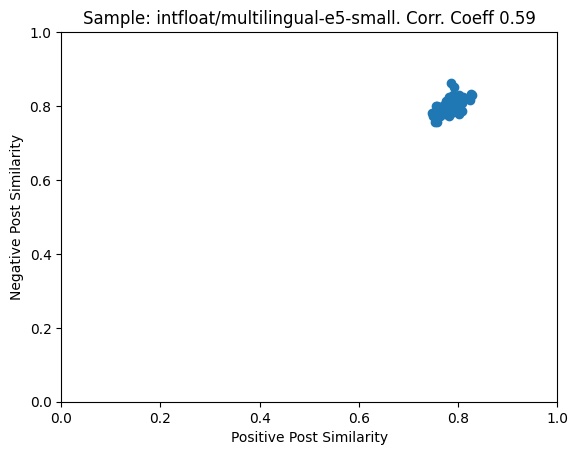

In [6]:
import matplotlib.pyplot as plt
for model in model_names:
    plt.scatter(cosine_dim_data[model + '_positive'], cosine_dim_data[model + '_negative'])
    
    correlation_coef = cosine_dim_data[model + '_positive'].corr(cosine_dim_data[model + '_negative'])
    
    plt.title('Sample: ' + model + '. Corr. Coeff ' + str(round(correlation_coef, 2)))

    # Set the x-axis range
    plt.xlim(0, 1)
    plt.xlabel('Positive Post Similarity')

    # y-axis range
    plt.ylim(0, 1)
    plt.ylabel('Negative Post Similarity')
    plt.show()

In [7]:
# Save cosine similarity dataset to drive
cosine_dim_data['positive_query'] = positive_query
cosine_dim_data['negative_query'] = negative_query

In [8]:
import sys

# set this on the path so that we can reference the commong data locations
sys.path.append("../../scripts/")
from data_collection import authenticate_google_drive, save_google_drive_data

# Grab the Google Drive object
drive = authenticate_google_drive('../0_data_collection/credentials/google_drive_client_secret.json')

save_google_drive_data(drive=drive, 
                           credential_file="../0_data_collection/credentials/google_drive_folder_id.json",  
                           dataframe = cosine_dim_data, 
                           filename='cosine_similarities_sampled.csv')

File 'cosine_similarities_sampled.csv' uploaded successfully to folder 1kJ6TrI9MVT5mfnnYvS-OpRMJFVbIQ6Tl!
